<a href="https://colab.research.google.com/github/JoDeMiro/DeepLearningIntroduction/blob/main/YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://user-images.githubusercontent.com/26833433/82952157-51b7db00-9f5d-11ea-8f4b-dda1ffecf992.jpg">


<!--- @wandbcode{yolov3-train} -->

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />


# Train and Debug YOLOv3 Models with Weights & Biases

In this colab,
I'll demonstrate how to use the W&B integration with
version 3 of the "You Only Look Once"
(aka [YOLOv5](https://github.com/ultralytics/yolov5))
real-time object detection framework
to track model metrics,
inspect model outputs,
and restart interrupted runs.

### Download YOLOv3 Weights

Hogy mégis fogalmunk legyen arról, hogy mekkora ez a YOLOv3 model, nem kicsi 265 MByte. Azonban ez nem csak egy modelt tartalmaz, hanem rögötön többet is.

Ha időközben az alábbi link megszűnne, akkor a saját gépemen is rajta van.

In [1]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-02-11 08:19:42--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  20.5MB/s    in 12s     

2022-02-11 08:19:55 (19.1 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



Szükség van még néhány konfugurációs fájlra, ahol a YOLO beállításai illetve az osztályok nevei vannak.

In [2]:
!mkdir cfg
!cd cfg
!wget https://raw.githubusercontent.com/JoDeMiro/Model/main/YOLOv3/cfg/yolov3.cfg -O cfg/yolov3.cfg

--2022-02-11 08:19:56--  https://raw.githubusercontent.com/JoDeMiro/Model/main/YOLOv3/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9129 (8.9K) [text/plain]
Saving to: ‘cfg/yolov3.cfg’

cfg/yolov3.cfg      100%[===================>]   8.92K  --.-KB/s    in 0s      

2022-02-11 08:19:56 (53.2 MB/s) - ‘cfg/yolov3.cfg’ saved [9129/9129]



In [3]:
!mkdir data
!cd data
!wget https://raw.githubusercontent.com/JoDeMiro/Model/main/YOLOv3/COCO/coco.names -O data/coco.names

--2022-02-11 08:19:56--  https://raw.githubusercontent.com/JoDeMiro/Model/main/YOLOv3/COCO/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 705 [text/plain]
Saving to: ‘data/coco.names’

data/coco.names     100%[===================>]     705  --.-KB/s    in 0s      

2022-02-11 08:19:56 (32.9 MB/s) - ‘data/coco.names’ saved [705/705]



Ez a későbbiek során majd megoldom, hogy feltöltéssel lehessen a képeket beküldeni, addig álljon itt egy egyszerűbb megoldás.

A feldolgozásra váró képeket egy adott könyvtárból fogjuk kiolvasni.

In [4]:
!mkdir images
!cd images
!wget https://github.com/JoDeMiro/Data/raw/main/Images/woman1.png -O images/woman1.png

--2022-02-11 08:19:57--  https://github.com/JoDeMiro/Data/raw/main/Images/woman1.png
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JoDeMiro/Data/main/Images/woman1.png [following]
--2022-02-11 08:19:57--  https://raw.githubusercontent.com/JoDeMiro/Data/main/Images/woman1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164047 (160K) [image/png]
Saving to: ‘images/woman1.png’

images/woman1.png   100%[===================>] 160.20K  --.-KB/s    in 0.008s  

2022-02-11 08:19:57 (19.6 MB/s) - ‘images/woman1.png’ saved [164047/164047]



In [5]:
# ezt a részt kihagyom de ha elhasal akkor visszatérünk rá

# !cp YOLOV3-Tutorial/pallete ./

## YOLOv3 Inference

In [6]:
import os
import time
import random
import argparse

import cv2

import numpy as np
import pandas as pd
import pickle as pkl

import os.path as osp

from __future__ import division

import torch
import torch.nn as nn
from torch.autograd import Variable


In [7]:
# Ezt át lehetne írni Notebookba is de átláthatatlanul hosszú lenne.

%%capture
!rm *.py*
!wget https://github.com/JoDeMiro/Model/raw/main/YOLOv3/darknet.py
!wget https://github.com/JoDeMiro/Model/raw/main/YOLOv3/util.py

from darknet import Darknet
from util import *

In [8]:
# Deffinie arguments

# Directory containing images to perform detection upon
images: str = 'images'

# Directory to store detections to
det: str = 'det'

# Batch size
batch_size: int = 1

# Object confidence to filter preidictions
confidence: float = 0.5

# NMS Threshold
nms_thesh: float = 0.4

# Cfg file path
# cfgfile: str = '\cfg\yolov3.cfg'
cfgfile: str = 'cfg/yolov3.cfg'

# Weights file path
weightsfile: str = 'yolov3.weights'

# Input resolution of the network. Increase to increase accuracy.
resolution: int = 416

# Class names
class_names_file: str = 'data/coco.names'

In [9]:
# Initialize

start = 0

CUDA = torch.cuda.is_available()

# Load Class names
fp = open(class_names_file, "r")
classes = fp.read().split("\n")[:-1]

num_classes = 80                        # Ez úgy jött ki, hogy ennyi
                                        # név van a 'data/coco.names'
                                        # fájlban.

num_classes = len(classes)              # Jobb, amikor a beolvasott
                                        # adatokból tudja

In [10]:
# Set up the neural network

print("Loading network.....")
model = Darknet(cfgfile)
model.load_weights(weightsfile)
print("Network successfully loaded")

Loading network.....
Network successfully loaded


In [11]:
# Set up the nerual network part two

model.net_info["height"] = resolution
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0
assert inp_dim > 32

# Vannak ilyen szépségek, melyekről ne esik szó a nagy könyvben
# például, hogy a model megköveteli, hogy a kép felbontása
# 32 többszöröse legyen - még szerencse

In [12]:
# Set up the neural network park tree, hehe

# If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()

# Set the model in evaluation mode
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

In [35]:
# Olvassuk be a feldolgozásra váró képeket a könyvtárból

try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    exit()

if not os.path.exists(det):
    os.makedirs(det)


# --

loaded_ims = [cv2.imread(x) for x in imlist]

# --

def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)

    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image

    return canvas


def prep_image(img, inp_dim):
    '''
    Prepare image for inputting to the neural network.

    Returns a Variable
    '''
    img = (letterbox_image(img, (inp_dim, inp_dim)))
    img = img[:,:,::-1].transpose((2,0,1)).copy()
    img = torch.from_numpy(img).float().div(255.0).unsqueeze(0)
    return img

# --

im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)


leftover = 0
if (len(im_dim_list) % batch_size):
    leftover = 1

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]

write = 0

if CUDA:
    im_dim_list = im_dim_list.cuda()

In [36]:
# Indul a detection

In [37]:
for i, batch in enumerate(im_batches):
#load the image
    start = time.time()
    if CUDA:
        batch = batch.cuda()
    with torch.no_grad():
        prediction = model(Variable(batch), CUDA)

    prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)

    end = time.time()

    if type(prediction) == int:

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
            print("{0:20s} {1:s}".format("Objects Detected:", ""))
            print("----------------------------------------------------------")
        continue

    prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist

    if not write:                      #If we have't initialised output
        output = prediction
        write = 1
    else:
        output = torch.cat((output,prediction))

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")

    if CUDA:
        torch.cuda.synchronize()
try:
    output
except NameError:
    print ("No detections were made")
    exit()

im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(416/im_dim_list,1)[0].view(-1,1)


output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2


output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])


output_recast = time.time()
class_load = time.time()
# colors = pkl.load(open("pallete", "rb"))
colors = get_colors()

draw = time.time()


def write(x, results):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
    color = random.choice(colors)
    label = "{0}".format(classes[cls])
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img


list(map(lambda x: write(x, loaded_ims), output))

det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format(det,x.split("/")[-1]))
# det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format(det,x.split("\\")[-1]))

list(map(cv2.imwrite, det_names, loaded_ims))


end = time.time()

print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
# print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
# print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
# print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
# print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
print("----------------------------------------------------------")


torch.cuda.empty_cache()

woman1.png           predicted in  1.323 seconds
Objects Detected:    person
----------------------------------------------------------
SUMMARY
----------------------------------------------------------
Task                     : Time Taken (in seconds)

Output Processing        : 0.000
Drawing Boxes            : 0.012
----------------------------------------------------------


In [38]:
# Ide kell írni még egy olyat
# hogy végig iterál a det könyvtáron és ami kép van benne azt
# megjeleníti

print(os.listdir(images))

print(os.listdir(det))

print(det)

print(images)

['woman1.png']
['det_woman1.png']
det
images


In [39]:
try:
  det_images = [osp.join(osp.realpath('.'), det, i) for i in os.listdir(det)]
except NotADirectoryError:
  det_images = []
  det_images.append(osp.join(osp.realpath('.'), det))
except FileNotFoundError:
  print('No file or directory with name {}'.format(det))

print(det_images)

['/content/det/det_woman1.png']


/content/det/det_woman1.png


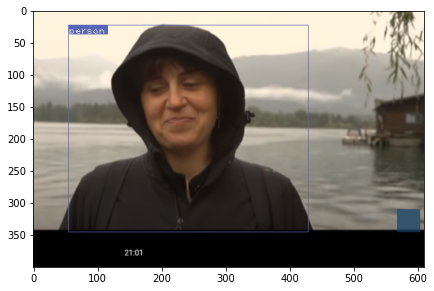

In [40]:
# megvan a lista ami a képek teljes elérési útját tartalmazza

# iteráljunk végig rajtuk és jelenítsük meg őket

import matplotlib.pyplot as plt
import skimage.io

for files in det_images:
  print(files)
  pic = skimage.io.imread(files)
  plt.figure(figsize=(7, 7))
  plt.imshow(pic)
  plt.show()
